In [1]:
import heeps
from heeps.util.img_processing import resize_cube
from heeps.util.multiCPU import multiCPU
import proper
import warnings
from copy import deepcopy
import os.path
from astropy.io import fits
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

## Input parameters

In [2]:
nzer = 100
nimg = 720
npupil = 285
date = '20210601'
duration = 3600
samp_wv = 100 # wv sampling in ms
samp_scao = 300 # scao sampling in ms
step = int(samp_scao/samp_wv)
temporal_rms = 8814.11
rms_L = 100
rms_N = 1200
ncube_psd = 100 # number of frames for PSD
nzer_psd = 20 # number of Z modes for PSD
pol_order = 3                       # filter polynomial order
win_size = 51                       # filter window size
savgol = True
# rainbow map colors
colors = np.array([cm.rainbow(i) for i in np.linspace(0, 1, nzer_psd)])
# initial wavefront
wf = proper.prop_begin(nimg, 1, nimg, 1)

In [3]:
dir_current = '/mnt/disk4tb/METIS/METIS_CBASIC_CUBES'
filename = 'cube_Cbasic_%s_%ss_%sms_0piston_meters_scao_only_%s.fits'
scao = os.path.join(dir_current, filename%('20201130', duration, samp_scao, npupil))
wv = os.path.join(dir_current, 'water_vapor', (filename%(date, duration, samp_wv, nimg))[:-5] + '_WV.fits')
pup = fits.getdata(os.path.join(dir_current, 'water_vapor/mask_Cbasic_20210601_720.fits'))
pup[pup < .5] = 0
# pup should NOT have NANs for prop_fit_zernikes

In [4]:
def get_piston(frame):
    return np.mean(frame[frame!=0])
def get_rms(frame):
    return np.std(frame[frame!=0])
def fit_zer(nzer, pup, phi, rad=nimg/2): # pup should NOT have NANs for prop_fit_zernikes
    return proper.prop_fit_zernikes(phi, pup, rad, nzer, eps=0, fit=True)
def get_zpols(phi_name, pup, nzer):
    zpols_name = phi_name[:-5] + '_zpols_%s.fits'%nzer
    try:
        zpols = fits.getdata(zpols_name)
        print('getdata ' + zpols_name)
    except FileNotFoundError:
        print('writeto ' + zpols_name)
        phi = fits.getdata(phi_name)
        zpols = multiCPU(fit_zer, posargs=[nzer, resize_cube(pup, phi.shape[1])], \
                         posvars=[phi], case='get zpols')
        fits.writeto(zpols_name, np.float32(zpols))
    return zpols
def remove_zernike(wf, pup, phi, zpols):
    proper.prop_add_phase(wf, phi)
    phiz = proper.prop_zernikes(wf, np.arange(len(zpols)) + 1, zpols)
    phiz[pup==0] = 0
    phih = phi - phiz    
    return phiz, phih
def remove_zernike_roll(phi_name, pup, nzer, zpols, nLF, nHF):
    for case in ['all_ncpa', 'scao_only']:
        wv_out = os.path.join(dir_current, 'water_vapor', (filename%(date, duration, samp_scao, npupil))[:-5] \
                + '_WV%s' + '_nLF_%s_nHF_%s.fits'%(nLF, nHF)).replace('scao_only', case)
        try:
            phil = fits.getdata(wv_out%'L')
            phin = fits.getdata(wv_out%'N')
            print('getdata ' + wv_out)
        except FileNotFoundError:
            zpols_roll_name = phi_name[:-5] + '_zpols_%s_nLF_%s_nHF_%s.fits'%(nzer, nLF, nHF)
            try:
                zpols_roll = fits.getdata(zpols_roll_name)
                print('getdata ' + zpols_roll_name)
            except FileNotFoundError:
                print('writeto ' + zpols_roll_name)
                zpols_roll = deepcopy(zpols)
                for i in range(len(zpols_roll)):
                    end = max(i, 1)
                    start = max(i-nLF, 0)
                    zpols_roll[i,1:3] = np.mean(zpols[start:end,1:3], 0)
                    start = max(i-nHF, 0)
                    zpols_roll[i,3:] = np.mean(zpols[start:end,3:], 0)
                fits.writeto(zpols_roll_name, np.float32(zpols_roll))            
            print('writeto ' + wv_out)
            phi = fits.getdata(phi_name)[::step]
            _, phi = multiCPU(remove_zernike, posargs=[deepcopy(wf), resize_cube(pup, phi.shape[1])], 
                    posvars=[phi, zpols_roll[::step]], case='remove zernike', nout=2, verbose=True)
            phi = resize_cube(phi, npupil)
            phil = np.float32(fits.getdata(scao.replace('scao_only', case)) + phi*(rms_L/temporal_rms))
            phin = np.float32(fits.getdata(scao.replace('scao_only', case)) + phi*(rms_N/temporal_rms))
            fits.writeto(wv_out%'L', phil, overwrite=True)
            fits.writeto(wv_out%'N', phin, overwrite=True)
    return phil, phin
def get_spsd(phi_name, pup, nzer_psd, ncube_psd):
    spsd_name = phi_name[:-5] + '_%s' + '_%s.fits'%nzer_psd
    try:
        spsd = fits.getdata(spsd_name%'spsd')
        print('getdata ' + spsd_name%'spsd')
    except FileNotFoundError:
        print('writeto ' + spsd_name%'spsd')
        phi = fits.getdata(phi_name)[:ncube_psd]
        LSFs = np.empty((nzer_psd, ncube_psd, nimg, nimg))
        HSFs = np.empty((nzer_psd, ncube_psd, nimg, nimg))
        HSFs_rms = []
        for z in np.arange(nzer_psd) + 1:
            verbose = False if z > 1 else True
            phiz, phih = multiCPU(remove_zernike, posargs=[deepcopy(wf), resize_cube(pup, phi.shape[1])], \
                    posvars=[phi, zpols[:ncube_psd,:z]], case='remove zernike', nout=2, verbose=verbose)
            LSFs[z-1], HSFs[z-1] = phiz, phih
            HSFs_rms.append(np.mean(multiCPU(get_rms, posvars=[phih], case='get rms', verbose=verbose)))
            print(z, end=', ')
        spsd = [(rms*1e9)**2 for rms in HSFs_rms]
        spsd = [spsd[0]] + spsd
        fits.writeto(spsd_name%'spsd', np.float32(spsd))
        fits.writeto(spsd_name%'LSFs', np.float32(LSFs))
        fits.writeto(spsd_name%'HSFs', np.float32(HSFs))
    return spsd
def get_tpsd(phi_name, pup, nzer, case):
    tpsd_name = phi_name[:-5] + '_tpsd.fits'
    try:
        tpsd = fits.getdata(tpsd_name)
        print('getdata ' + tpsd_name)
    except FileNotFoundError:
        print('writeto ' + tpsd_name)
        phi = fits.getdata(phi_name)
        zpols = multiCPU(fit_zer, posargs=[nzer, resize_cube(pup, phi.shape[1])], \
                 posvars=[phi], case=case)
        N = len(phi)            # cube size in the time domain
        M = N // 2 + 1          # cube size in the frequency domain
        yf = np.abs(np.array([np.fft.fft(yt)[:M] for yt in zpols.swapaxes(0,1)]))
        if savgol is True:  # savgol filter 
            warnings.filterwarnings("ignore")
            yf = savgol_filter(yf, win_size, pol_order)
        tpsd = yf**2
        fits.writeto(tpsd_name, np.float32(tpsd))
    return tpsd
def plot_tpsd(y1, label1, y2, label2, title, z=[1,2,3,4,8,12,16,20]):
    x = np.arange(y1.shape[1])/duration
    plt.figure(figsize=(12,6))
    plt.grid(True), plt.grid(which='minor', linestyle=':')
    for ys, label, ls in zip([y1, y2], [label1, label2], ['-', ':']):
        for i, y in enumerate(ys):
            color = 'k' if i==0 else colors[i-1]
            if i+1 in z:
                plt.loglog(x, y, color=color, label='Z%s %s'%(i+1, label), linestyle=ls)
    plt.legend(ncol=2, fontsize='small')
    plt.xlim((1e-2, max(x)))
    plt.ylim((1e-13, 1e-3))
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Temporal PSD [Z^2/Hz]')
    plt.savefig('WV_temp_psd_Z%s_%s.png'%(nzer, title.replace(' ', '_')), dpi=300, transparent=True)            

## 1/ SCAO + WV

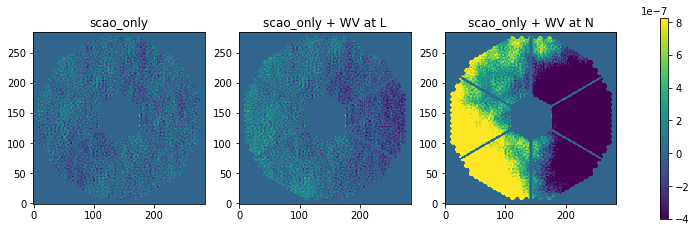

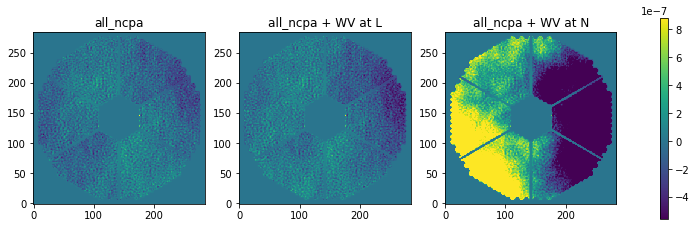

In [5]:
i = 20 # frame number
for case in ['scao_only', 'all_ncpa']:
    wv_out = os.path.join(dir_current, 'water_vapor', (filename%(date, duration, samp_scao, npupil))[:-5] \
            + '_WV%s.fits').replace('scao_only', case)
    if not os.path.isfile(wv_out%'N'):
        print('writeto %s'%wv_out)
        cube = resize_cube(fits.getdata(wv)[::step], npupil)
        fits.writeto(wv_out%'L', np.float32(fits.getdata(scao.replace('scao_only', case)) \
                                            + cube*(rms_L/temporal_rms)), overwrite=True)
        fits.writeto(wv_out%'N', np.float32(fits.getdata(scao.replace('scao_only', case)) \
                                            + cube*(rms_N/temporal_rms)), overwrite=True) 
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
    plt.subplot(131); plt.title(case)
    im = plt.imshow(fits.getdata(scao.replace('scao_only', case))[i], origin=True)
    vmin, vmax = plt.gci().get_clim()
    plt.subplot(132); plt.title('%s + WV at L'%case)
    plt.imshow(fits.getdata(wv_out%'L')[i], origin=True, vmin=vmin, vmax=vmax)
    plt.subplot(133); plt.title('%s + WV at N'%case)
    plt.imshow(fits.getdata(wv_out%'N')[i], origin=True, vmin=vmin, vmax=vmax)
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
    fig.colorbar(im, cax=cbar_ax);

## 2/ Spatial PSD

getdata /mnt/disk4tb/METIS/METIS_CBASIC_CUBES/water_vapor/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_zpols_100.fits
getdata /mnt/disk4tb/METIS/METIS_CBASIC_CUBES/water_vapor/cube_Cbasic_20210601_3600s_100ms_0piston_meters_scao_only_720_WV_spsd_20.fits


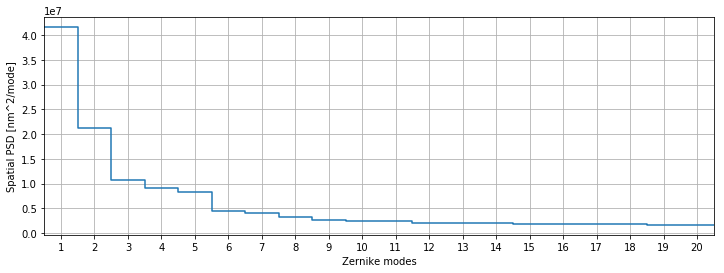

In [6]:
zpols = get_zpols(wv, pup, nzer)
spsd = get_spsd(wv, pup, nzer_psd, ncube_psd)
plt.figure(figsize=(12,4))
plt.grid(True), plt.grid(which='minor', linestyle=':')
x = np.arange(nzer_psd + 1) + .5
plt.plot(x, spsd, ls='steps')
plt.xlabel('Zernike modes')
plt.ylabel('Spatial PSD [nm^2/mode]')
plt.xlim((.5, nzer_psd + .5))
plt.xticks(np.arange(nzer_psd) + 1)
plt.savefig('WV_spat_psd_Z%s.png'%nzer_psd, dpi=300, transparent=True)

### one frame example

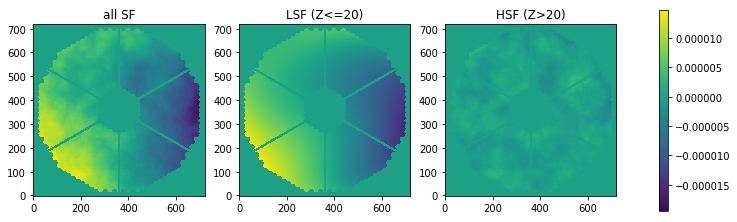

In [7]:
i = 20*step # frame number
spsd_name = wv[:-5] + '_%s' + '_%s.fits'%nzer_psd
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
plt.subplot(131); im = plt.imshow(fits.getdata(wv)[i], origin=True); plt.title('all SF')
vmin, vmax = plt.gci().get_clim()
plt.subplot(132); plt.title('LSF (Z<=%s)'%nzer_psd)
plt.imshow(fits.getdata(spsd_name%'LSFs')[-1,i], origin=True, vmin=vmin, vmax=vmax)
plt.subplot(133); plt.title('HSF (Z>%s)'%nzer_psd)
plt.imshow(fits.getdata(spsd_name%'HSFs')[-1,i], origin=True, vmin=vmin, vmax=vmax)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax);

## 3/ Remove Zernike (close-loop in rolling average)

In [8]:
#freqs = [(1,1), (1,10), (1,100)]
freqs = [(1,10)]
for nLF, nHF in freqs:
    phil, phin = remove_zernike_roll(wv, pup, nzer, zpols, nLF, nHF)   

getdata /mnt/disk4tb/METIS/METIS_CBASIC_CUBES/water_vapor/cube_Cbasic_20210601_3600s_300ms_0piston_meters_all_ncpa_285_WV%s_nLF_1_nHF_10.fits
getdata /mnt/disk4tb/METIS/METIS_CBASIC_CUBES/water_vapor/cube_Cbasic_20210601_3600s_300ms_0piston_meters_scao_only_285_WV%s_nLF_1_nHF_10.fits


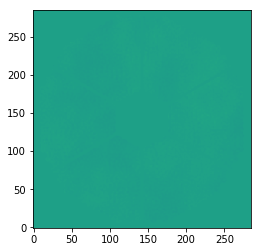

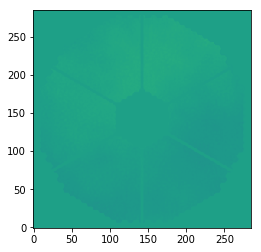

In [9]:
plt.imshow(phin[20], origin=True, vmin=vmin, vmax=vmax)
plt.figure()
plt.imshow(fits.getdata(wv_out%'N')[60], origin=True, vmin=vmin, vmax=vmax)

## 4/ Temporal PSD

### water vapor only

getdata /mnt/disk4tb/METIS/METIS_CBASIC_CUBES/cube_Cbasic_20201130_3600s_300ms_0piston_meters_scao_only_285_tpsd.fits
getdata /mnt/disk4tb/METIS/METIS_CBASIC_CUBES/water_vapor/cube_Cbasic_20210601_3600s_300ms_0piston_meters_scao_only_285_WVLonly_tpsd.fits
getdata /mnt/disk4tb/METIS/METIS_CBASIC_CUBES/water_vapor/cube_Cbasic_20210601_3600s_300ms_0piston_meters_scao_only_285_WVNonly_tpsd.fits


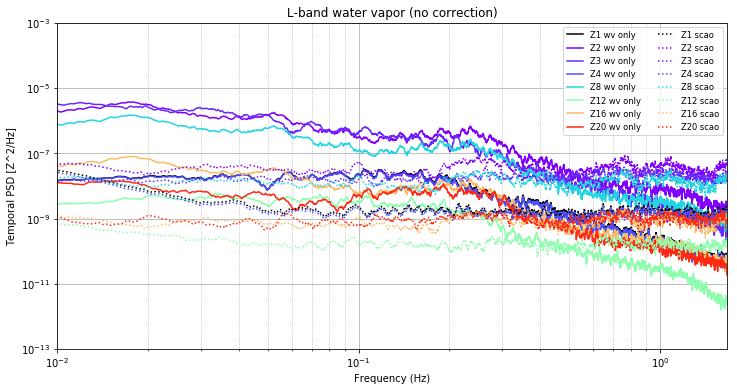

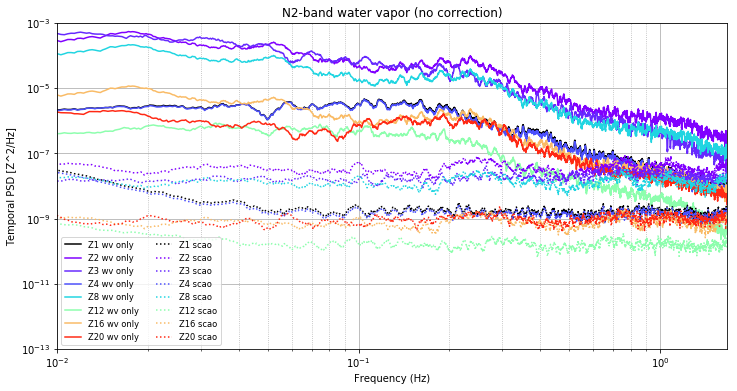

In [10]:
tpsd_scao = get_tpsd(scao, pup, nzer_psd, 'tpsd_scao')
wv_out = os.path.join(dir_current, 'water_vapor', (filename%(date, duration, samp_scao, npupil))[:-5] + '_WV%s.fits')
tpsd_wvl = get_tpsd(wv_out%'Lonly', pup, nzer_psd, 'tpsd_wvl')
tpsd_wvn = get_tpsd(wv_out%'Nonly', pup, nzer_psd, 'tpsd_wvn')
plot_tpsd(tpsd_wvl, 'wv only', tpsd_scao, 'scao', 'L-band water vapor (no correction)')
plot_tpsd(tpsd_wvn, 'wv only', tpsd_scao, 'scao', 'N2-band water vapor (no correction)')

### scao + water vapor (QACITS 10Hz, PSI 1Hz)

getdata /mnt/disk4tb/METIS/METIS_CBASIC_CUBES/water_vapor/cube_Cbasic_20210601_3600s_300ms_0piston_meters_scao_only_285_WVL_nLF_1_nHF_10_tpsd.fits
getdata /mnt/disk4tb/METIS/METIS_CBASIC_CUBES/water_vapor/cube_Cbasic_20210601_3600s_300ms_0piston_meters_scao_only_285_WVN_nLF_1_nHF_10_tpsd.fits


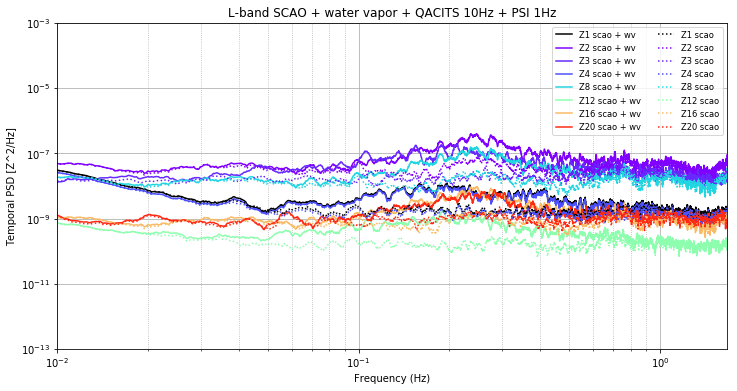

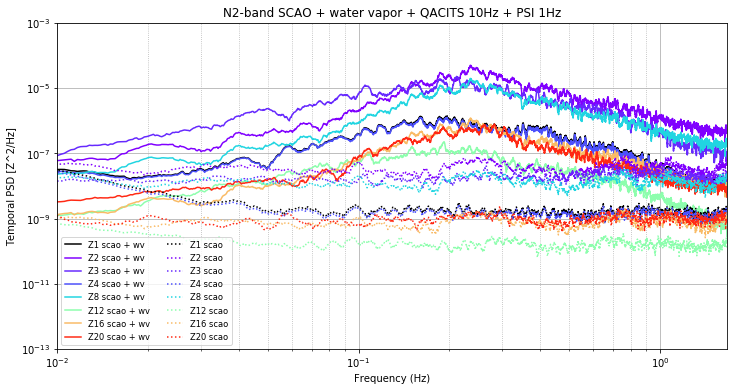

In [11]:
tpsd_wvl = get_tpsd(wv_out%'L_nLF_1_nHF_10', pup, nzer_psd, 'tpsd_wvl')
tpsd_wvn = get_tpsd(wv_out%'N_nLF_1_nHF_10', pup, nzer_psd, 'tpsd_wvn')
plot_tpsd(tpsd_wvl, 'scao + wv', tpsd_scao, 'scao', 'L-band SCAO + water vapor + QACITS 10Hz + PSI 1Hz')
plot_tpsd(tpsd_wvn, 'scao + wv', tpsd_scao, 'scao', 'N2-band SCAO + water vapor + QACITS 10Hz + PSI 1Hz')

### ncpa + water vapor (QACITS 10Hz, PSI 1Hz)

getdata /mnt/disk4tb/METIS/METIS_CBASIC_CUBES/cube_Cbasic_20201130_3600s_300ms_0piston_meters_all_ncpa_285_tpsd.fits
getdata /mnt/disk4tb/METIS/METIS_CBASIC_CUBES/water_vapor/cube_Cbasic_20210601_3600s_300ms_0piston_meters_all_ncpa_285_WVL_nLF_1_nHF_10_tpsd.fits
getdata /mnt/disk4tb/METIS/METIS_CBASIC_CUBES/water_vapor/cube_Cbasic_20210601_3600s_300ms_0piston_meters_all_ncpa_285_WVN_nLF_1_nHF_10_tpsd.fits


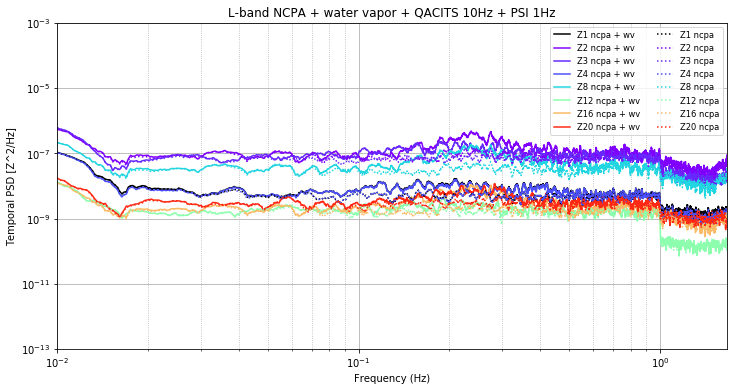

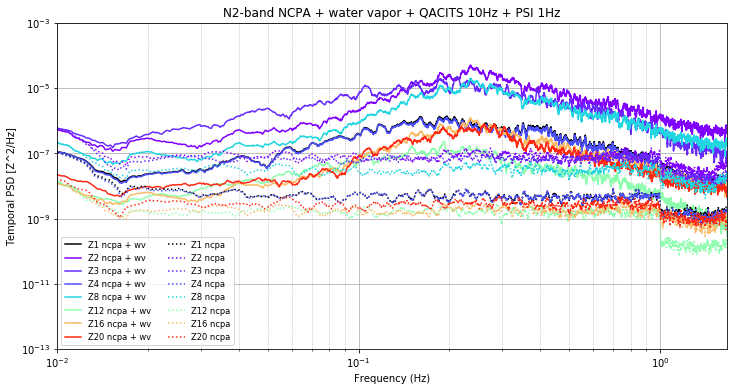

In [12]:
tpsd_ncpa = get_tpsd(scao.replace('scao_only', 'all_ncpa'), pup, nzer_psd, 'tpsd_ncpa')
tpsd_wvl = get_tpsd((wv_out%'L_nLF_1_nHF_10').replace('scao_only', 'all_ncpa'), pup, nzer_psd, 'tpsd_wvl')
tpsd_wvn = get_tpsd((wv_out%'N_nLF_1_nHF_10').replace('scao_only', 'all_ncpa'), pup, nzer_psd, 'tpsd_wvn')
plot_tpsd(tpsd_wvl, 'ncpa + wv', tpsd_ncpa, 'ncpa', 'L-band NCPA + water vapor + QACITS 10Hz + PSI 1Hz')
plot_tpsd(tpsd_wvn, 'ncpa + wv', tpsd_ncpa, 'ncpa', 'N2-band NCPA + water vapor + QACITS 10Hz + PSI 1Hz')

## 5/ WFE fluctuations

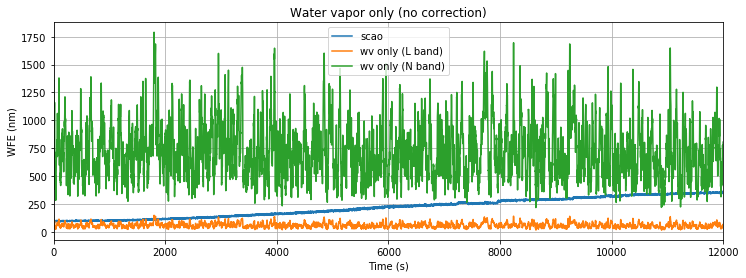

In [13]:
wfe_scao = np.array([get_rms(x) for x in fits.getdata(scao)])
wfe_wvl = np.array([get_rms(x) for x in fits.getdata(wv_out%'Lonly')])
wfe_wvn = np.array([get_rms(x) for x in fits.getdata(wv_out%'Nonly')])
plt.figure(figsize=(12,4))
plt.grid(True), plt.grid(which='minor', linestyle=':')
plt.plot(wfe_scao*1e9, label='scao')
plt.plot(wfe_wvl*1e9, label='wv only (L band)')
plt.plot(wfe_wvn*1e9, label='wv only (N band)')
plt.xlabel('Time (s)')
plt.ylabel('WFE (nm)')
plt.title('Water vapor only (no correction)')
plt.xlim((0,12000))
plt.legend();

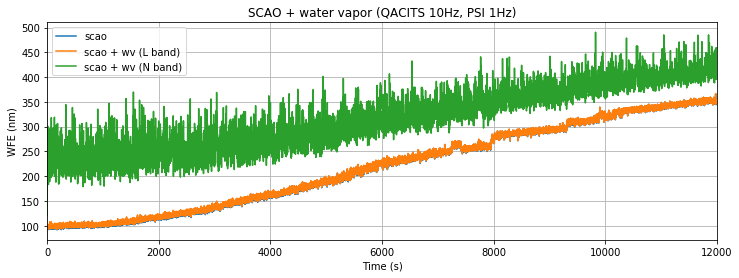

In [14]:
wfe_scao = np.array([get_rms(x) for x in fits.getdata(scao)])
wfe_wvl = np.array([get_rms(x) for x in fits.getdata(wv_out%'L_nLF_1_nHF_10')])
wfe_wvn = np.array([get_rms(x) for x in fits.getdata(wv_out%'N_nLF_1_nHF_10')])
plt.figure(figsize=(12,4))
plt.grid(True), plt.grid(which='minor', linestyle=':')
plt.plot(wfe_scao*1e9, label='scao')
plt.plot(wfe_wvl*1e9, label='scao + wv (L band)')
plt.plot(wfe_wvn*1e9, label='scao + wv (N band)')
plt.xlabel('Time (s)')
plt.ylabel('WFE (nm)')
plt.title('SCAO + water vapor (QACITS 10Hz, PSI 1Hz)')
plt.xlim((0,12000))
plt.legend();

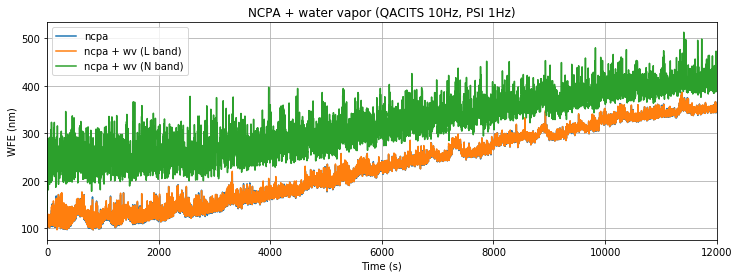

In [15]:
wfe_ncpa = np.array([get_rms(x) for x in fits.getdata(scao.replace('scao_only','all_ncpa'))])
wfe_wvl = np.array([get_rms(x) for x in fits.getdata((wv_out%'L_nLF_1_nHF_10').replace('scao_only','all_ncpa'))])
wfe_wvn = np.array([get_rms(x) for x in fits.getdata((wv_out%'N_nLF_1_nHF_10').replace('scao_only','all_ncpa'))])
plt.figure(figsize=(12,4))
plt.grid(True), plt.grid(which='minor', linestyle=':')
plt.plot(wfe_ncpa*1e9, label='ncpa')
plt.plot(wfe_wvl*1e9, label='ncpa + wv (L band)')
plt.plot(wfe_wvn*1e9, label='ncpa + wv (N band)')
plt.xlabel('Time (s)')
plt.ylabel('WFE (nm)')
plt.title('NCPA + water vapor (QACITS 10Hz, PSI 1Hz)')
plt.xlim((0,12000))
plt.legend();